## Perceptron class


**Perceptron**

- single `neuron` connected to a `Sigmoid` activation function.

**Sigmoid**

- Useful in `logistic regression`: prediction of binary classification
- Limited values: [0, 1]: https://www.youtube.com/watch?v=TPqr8t919YM

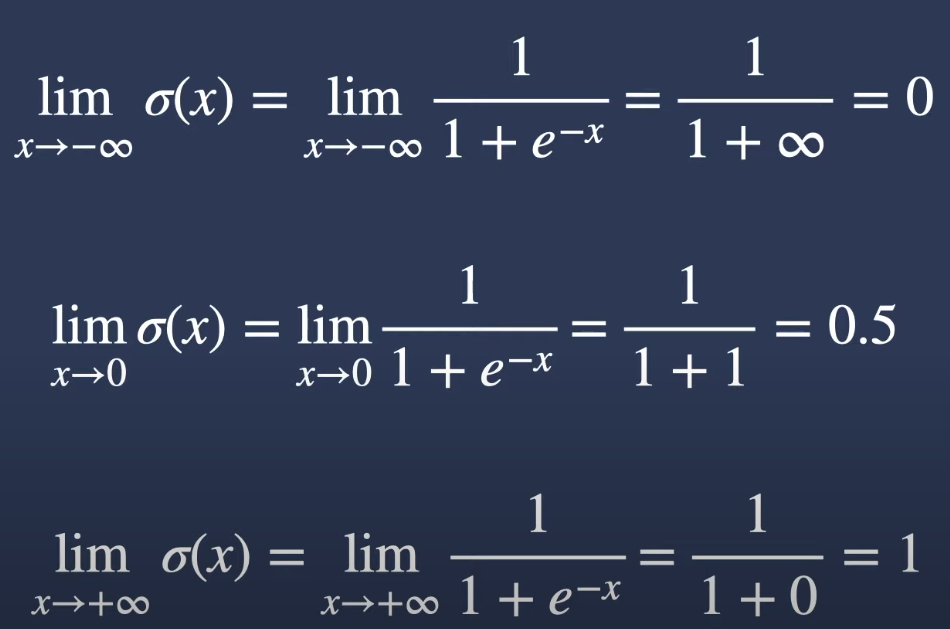

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from mikroml.training import *
from mikroml.datasets import *

In [2]:
class Perceptron(nn.Module):
    """ 
    Perceptron with a single neuron whose output is passed to a Sigmoid.
    INPUT: input_dim - number of input features.
    """
    def __init__(self, nof_features):
        super().__init__()
        self.weights = nn.Parameter(torch.rand(size=(nof_features, 1)))
        self.bias = nn.Parameter(torch.rand(size=(1, 1)))
        self.activation = nn.Sigmoid()
        
    def forward(self, x):
        return self.l2(self.l1(x))
        
    def l1(self, inp):
        return inp @ self.weights + self.bias
    
    def l2(self, inp):
        return self.activation(inp)

In [3]:
perceptron = Perceptron(3)

Extract parameters.

In [4]:
list(perceptron.parameters())

[Parameter containing:
 tensor([[0.2562],
         [0.7893],
         [0.4689]], requires_grad=True),
 Parameter containing:
 tensor([[0.6747]], requires_grad=True)]

Test if the produced output corresponds to `y = w * x + b` as expected.

In [5]:
n1_i1_perceptron = Perceptron(1)
for x in [0, 1, 10, 100, -1, -10, -100]:
    inp = torch.tensor([x], dtype=torch.float)
    print(f"Input: {inp}, Output: {n1_i1_perceptron(inp)}")

Input: tensor([0.]), Output: tensor([[0.6526]], grad_fn=<SigmoidBackward0>)
Input: tensor([1.]), Output: tensor([[0.7724]], grad_fn=<SigmoidBackward0>)
Input: tensor([10.]), Output: tensor([[0.9986]], grad_fn=<SigmoidBackward0>)
Input: tensor([100.]), Output: tensor([[1.]], grad_fn=<SigmoidBackward0>)
Input: tensor([-1.]), Output: tensor([[0.5099]], grad_fn=<SigmoidBackward0>)
Input: tensor([-10.]), Output: tensor([[0.0051]], grad_fn=<SigmoidBackward0>)
Input: tensor([-100.]), Output: tensor([[4.0377e-26]], grad_fn=<SigmoidBackward0>)


## `AND` dataset

**Truth table**

| IN1 | IN2 | OUT |
|-----|-----|-----|
| 0   | 0   | 0   |
| 0   | 1   | 0   |
| 1   | 0   | 0   |
| 1   | 1   | 1   |

1000 - training samples

100  - test samples

### Train dataset

In [6]:
x_train, y_train = torch.tensor([
    [0, 0],
    [0, 1],
    [1, 0],
    [1, 1]], dtype=torch.float
), torch.tensor([
    [0],
    [0],
    [0],
    [1]], dtype=torch.float
)

In [7]:
x_train.shape, y_train.shape

(torch.Size([4, 2]), torch.Size([4, 1]))

### Validation dataset

In [8]:
x_valid = torch.randint(low=0, high=2, size=(10, 2), dtype=torch.float)
x_valid, x_valid.shape

(tensor([[1., 0.],
         [1., 1.],
         [0., 0.],
         [0., 0.],
         [1., 0.],
         [1., 0.],
         [1., 0.],
         [1., 0.],
         [1., 1.],
         [1., 0.]]),
 torch.Size([10, 2]))

In [9]:
y_valid = map(lambda x: 1 if (x[0]==1) and (x[1]==1) else 0, x_valid)
y_valid = torch.tensor(list(y_valid), dtype=torch.float)

In [10]:
y_valid, y_valid.shape

(tensor([0., 1., 0., 0., 0., 0., 0., 0., 1., 0.]), torch.Size([10]))

## Model (AND gate)

- **Has 2 number of input features:**

The `AND` gate has 2 inputs, so we set the number of input features to 2.


- **SGD Optmizier:**

Stohastic gradient descend.


- **Use `Binary Cross Entropy - BCE` loss function:**

Measures the difference between binary outcomes and actual binary labels.

Ref: https://www.youtube.com/watch?v=DPSXVJF5jIs


In [11]:
and_classifier = Perceptron(2)
optimizer = torch.optim.SGD(and_classifier.parameters(), lr=0.1)
loss_func = nn.BCELoss()

In [12]:
# Original parameters
list(and_classifier.parameters())

[Parameter containing:
 tensor([[0.9969],
         [0.3926]], requires_grad=True),
 Parameter containing:
 tensor([[0.2130]], requires_grad=True)]

## Training

In [13]:
def perc_accuracy(preds, targs) -> float:
    """ The average accuracy of the correctly predicted numbers """
    preds.round_()
    preds.squeeze_()
    return (preds==y_valid).float().mean()

In [14]:
def fit_perceptron(epochs, model, loss_func, opt, x_train, y_train):
    for e in range(epochs):
        
        cumulative_preds = torch.Tensor()
        cumulative_targs = torch.Tensor()
        epoch_total_loss = 0
        nof_samples = 0
        
        for xb, targ in zip(x_train, y_train):
            preds = model(xb).squeeze(0)
            loss = loss_func(preds, targ)
            
            epoch_total_loss += loss
            cumulative_preds = torch.cat((cumulative_preds, preds))
            cumulative_targs = torch.cat((cumulative_targs, targ))
            train_loss = loss_func(preds, targ)
            nof_samples += 1

            loss.backward()
            opt.step()
            opt.zero_grad()
        if e%10 == 0:
            print(f"Epoch:{e}, Loss:{epoch_total_loss:0.3f}")

In [15]:
fit_perceptron(100, and_classifier, loss_func, optimizer, x_train, y_train)

Epoch:0, Loss:3.439
Epoch:10, Loss:2.083
Epoch:20, Loss:1.805
Epoch:30, Loss:1.626
Epoch:40, Loss:1.484
Epoch:50, Loss:1.367
Epoch:60, Loss:1.269
Epoch:70, Loss:1.186
Epoch:80, Loss:1.114
Epoch:90, Loss:1.050


In [16]:
# Trained parameters
list(and_classifier.parameters())

[Parameter containing:
 tensor([[1.9712],
         [1.8728]], requires_grad=True),
 Parameter containing:
 tensor([[-3.1043]], requires_grad=True)]

## Validation

In [17]:
# Validation
preds = torch.Tensor()
for xb, yb in zip(x_valid, y_valid):
    preds = torch.cat((preds, and_classifier(xb)))    

In [18]:
preds, y_valid

(tensor([[0.2436],
         [0.6769],
         [0.0429],
         [0.0429],
         [0.2436],
         [0.2436],
         [0.2436],
         [0.2436],
         [0.6769],
         [0.2436]], grad_fn=<CatBackward0>),
 tensor([0., 1., 0., 0., 0., 0., 0., 0., 1., 0.]))

In [19]:
x_valid

tensor([[1., 0.],
        [1., 1.],
        [0., 0.],
        [0., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 1.],
        [1., 0.]])

In [20]:
# Validation of the results by hand.
# Important: weights change when you re-create the model
torch.sigmoid(torch.tensor(1*1.7793 + 1*1.8198 -2.9283))

tensor(0.6617)

If prediction>0.5 that means that the expected result should be 1.

Training for more epochs produces predictions which are closer to the actual targets.

There's an infinite number of parameter combinations which produces the same result.

In [21]:
perc_accuracy(preds, y_valid)

tensor(1.)

----

## `OR` dataset

**Truth table**

| IN1 | IN2 | OUT |
|-----|-----|-----|
| 0   | 0   | 0   |
| 0   | 1   | 1   |
| 1   | 0   | 1   |
| 1   | 1   | 1   |

1000 - training samples

100  - test samples

### Train dataset

In [22]:
x_train, y_train = torch.tensor([
    [0, 0],
    [0, 1],
    [1, 0],
    [1, 1]], dtype=torch.float
), torch.tensor([
    [0],
    [1],
    [1],
    [1]], dtype=torch.float
)

### Validation dataset

In [23]:
x_valid = torch.randint(low=0, high=2, size=(10, 2), dtype=torch.float)
x_valid, x_valid.shape

(tensor([[1., 1.],
         [0., 0.],
         [0., 1.],
         [0., 1.],
         [0., 1.],
         [1., 0.],
         [1., 1.],
         [1., 0.],
         [1., 0.],
         [0., 0.]]),
 torch.Size([10, 2]))

In [24]:
y_valid = map(lambda x: 1 if (x[0]==1) or (x[1]==1) else 0, x_valid)
y_valid = torch.tensor(list(y_valid), dtype=torch.float)

In [25]:
y_valid

tensor([1., 0., 1., 1., 1., 1., 1., 1., 1., 0.])

## Model (OR gate)

In [26]:
or_classifier = Perceptron(2)
optimizer = torch.optim.SGD(or_classifier.parameters(), lr=0.1)
loss_func = nn.BCELoss()

In [27]:
# Untrained parameters
list(or_classifier.parameters())

[Parameter containing:
 tensor([[0.1018],
         [0.2748]], requires_grad=True),
 Parameter containing:
 tensor([[0.8395]], requires_grad=True)]

In [28]:
# Fit model
fit_perceptron(100, or_classifier, loss_func, optimizer, x_train, y_train)

Epoch:0, Loss:2.092
Epoch:10, Loss:1.764
Epoch:20, Loss:1.554
Epoch:30, Loss:1.386
Epoch:40, Loss:1.247
Epoch:50, Loss:1.131
Epoch:60, Loss:1.033
Epoch:70, Loss:0.949
Epoch:80, Loss:0.877
Epoch:90, Loss:0.815


In [29]:
# Trained parameters
list(or_classifier.parameters())

[Parameter containing:
 tensor([[2.4141],
         [2.4681]], requires_grad=True),
 Parameter containing:
 tensor([[-0.5271]], requires_grad=True)]

## Validation

In [30]:
# Validation
preds = torch.Tensor()
for xb, yb in zip(x_valid, y_valid):
    preds = torch.cat((preds, or_classifier(xb)))    

In [31]:
preds, y_valid

(tensor([[0.9873],
         [0.3712],
         [0.8745],
         [0.8745],
         [0.8745],
         [0.8684],
         [0.9873],
         [0.8684],
         [0.8684],
         [0.3712]], grad_fn=<CatBackward0>),
 tensor([1., 0., 1., 1., 1., 1., 1., 1., 1., 0.]))

In [32]:
perc_accuracy(preds, y_valid)

tensor(1.)

## Sigmoid function

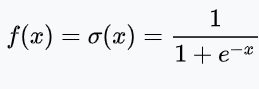

### How to implement it in hardware (VHDL)??

There are 3 options:

- using predefined vaues and storing them in LUT - ROM based approach: https://www.scielo.org.mx/pdf/jart/v1n3/v1n3a6.pdf
- using piecewise ...
- using cordic to calculate the value of sigmoid

### Sigmoid implementation with LUTs - ROM

1) precompute the `INPUT` of the `Sigmoid` - Neuron output
2) Precompute the `Sigmoid` `OUTPUT`
3) Divide `INPUT` and `OUTPUT` into a fixed number of bits - indexing the ROM <-- address

```text
TL;DR

Iterate through the possible input values based on your quantization.
For each input value, calculate the corresponding sigmoid function output.
Store the calculated sigmoid value (quantized to your desired output format) in the corresponding index of the rom_data array.
```

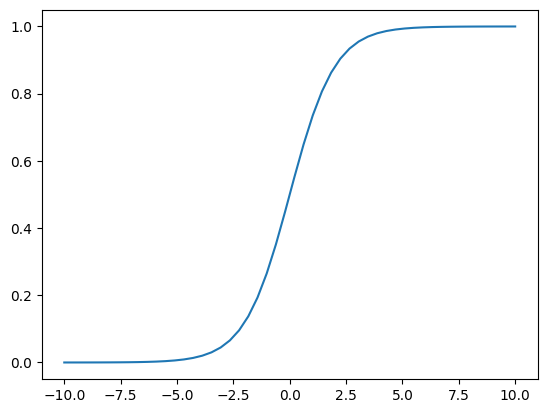

In [33]:
import matplotlib.pyplot as plt
import numpy as np

x = np.linspace(-10, 10, 50)
plt.plot(x, 1/(1+np.exp(-x)))

In [34]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

In [35]:
# Validate outputs from Neuron in VHDL with values from sigmoid for all possible input values
print(sigmoid(0.6617))   # in1:1 in2:1
print(sigmoid(-1.15234)) # in1:1 in2:0
print(sigmoid(-1.11328)) # in1:0 in2:1
print(sigmoid(-2.92188)) # in1:0 in2:0

0.6596421664145986
0.24006193207907128
0.24725990099620573
0.0510824945911418


---

---

# Multi Layer Perceptron - MLP

Let's create an MLP for the MNIST dataset and export its parameters for the VHDL ANN.

In [36]:
# Fetch MNIST dataset
mnist_ds = MNIST_Dataset()

In [37]:
# Set Neural Network architecture
nof_categories = max(mnist_ds.train_y)+1
nof_inputs = mnist_ds.train_x.shape[-1]
nof_hidden_layers = 10

In [38]:
class MLP(nn.Module):
    def __init__(self, nof_inputs, nof_outputs, nof_hidden):
        super().__init__()
        self.layer1 = nn.Linear(nof_inputs, nof_hidden)
        self.layer2 = nn.ReLU()
        self.layer3 = nn.Linear(nof_hidden, nof_outputs)

    def forward(self, x):
        return self.layer3(self.layer2(self.layer1(x)))

In [39]:
# Create MLP
mnist_mlp = MLP(nof_inputs, nof_categories, nof_hidden_layers)

In [40]:
# Model shape
print(mnist_mlp)

MLP(
  (layer1): Linear(in_features=784, out_features=10, bias=True)
  (layer2): ReLU()
  (layer3): Linear(in_features=10, out_features=10, bias=True)
)


In [41]:
# Total number of parameters
def get_total_nof_parameters(model):
    return sum(p.numel() for p in model.parameters())

In [42]:
get_total_nof_parameters(mnist_mlp)

7960

In [43]:
def get_some_params(model):
    for p in model.parameters():
        print(p.shape)
        try:
            print(p[0][:10])
        except:
            pass

In [44]:
# Some of the original parameters - untrained
get_some_params(mnist_mlp)

torch.Size([10, 784])
tensor([ 0.0025,  0.0285,  0.0302, -0.0306,  0.0261,  0.0047, -0.0352, -0.0218,
         0.0115,  0.0173], grad_fn=<SliceBackward0>)
torch.Size([10])
torch.Size([10, 10])
tensor([ 0.2209,  0.0696,  0.0596,  0.0364,  0.1235, -0.2297,  0.2682, -0.2545,
         0.0836,  0.1079], grad_fn=<SliceBackward0>)
torch.Size([10])


In [45]:
# Create dataloaders
bs = 64
train_ds = Dataset(mnist_ds.train_x, mnist_ds.train_y)
valid_ds = Dataset(mnist_ds.valid_x, mnist_ds.valid_y)
train_dl = DataLoader(train_ds, bs, shuffle=True, drop_last=True, num_workers=2)
valid_dl = DataLoader(valid_ds, bs, shuffle=False, drop_last=False, num_workers=2)

In [46]:
train_ds[:3], valid_ds[:3]

((array([[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]], dtype=float32),
  array([5, 0, 4])),
 (array([[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]], dtype=float32),
  array([3, 8, 6])))

In [47]:
import torch.nn.functional as F
from torch import optim

optimizer = optim.SGD(mnist_mlp.parameters(), lr=0.5)
epochs = 10

fit(epochs, mnist_mlp, F.cross_entropy, optimizer, train_dl, valid_dl)

Training report
epoch:0
#-------------------------#
accuracy:0.822 	 loss:0.57075
#=========================#
Validation report
valid accuracy: 0.89	 valid loss: 0.38

Training report
epoch:1
#-------------------------#
accuracy:0.882 	 loss:0.40003
#=========================#
Validation report
valid accuracy: 0.876	 valid loss: 0.418

Training report
epoch:2
#-------------------------#
accuracy:0.896 	 loss:0.36219
#=========================#
Validation report
valid accuracy: 0.9	 valid loss: 0.355

Training report
epoch:3
#-------------------------#
accuracy:0.901 	 loss:0.34403
#=========================#
Validation report
valid accuracy: 0.909	 valid loss: 0.321

Training report
epoch:4
#-------------------------#
accuracy:0.904 	 loss:0.33565
#=========================#
Validation report
valid accuracy: 0.915	 valid loss: 0.285

Training report
epoch:5
#-------------------------#
accuracy:0.908 	 loss:0.32166
#=========================#
Validation report
valid accuracy: 0.916	 val

(0.265784421223402, tensor(0.9284))

In [48]:
# Extract same parameters after training
get_some_params(mnist_mlp)

torch.Size([10, 784])
tensor([ 0.0025,  0.0285,  0.0302, -0.0306,  0.0261,  0.0047, -0.0352, -0.0218,
         0.0115,  0.0173], grad_fn=<SliceBackward0>)
torch.Size([10])
torch.Size([10, 10])
tensor([ 0.5321,  0.1335, -0.2392,  0.0351, -1.6210,  0.0694,  1.1171, -1.4551,
         0.5681,  0.1141], grad_fn=<SliceBackward0>)
torch.Size([10])
